In [13]:
import pandas as pd
import pymc3 as pm
import theano.tensor as tt

In [14]:
mu = pd.read_csv("./data/matchups.csv")
mu.head()

,deck,versus,won,lost
0,Spirits,Cheerios,3,1
1,Spirits,W/U Control,12,6
2,Spirits,Ironworks,15,9
3,Spirits,Elves,6,4
4,Spirits,Death's Shadow,15,10


In [15]:
all_decks = list(set(mu.deck.unique().tolist() + mu.versus.unique().tolist()))

In [16]:
## make sure we don't overcount

mat = mu.assign(rec = mu.apply(lambda r: (r.won, r.lost), axis = "columns")).set_index(["deck", "versus"]).rec.unstack(1)
mat = mat.reindex(all_decks).reindex(all_decks, axis = "columns")

In [17]:
def switch_to_alphabetic(r):
    if r.deck > r.versus:
        return pd.Series({
            "deck": r.versus,
            "over": r.deck,
            "won": r.lost,
            "lost": r.won
        })
    
    return pd.Series({
        "deck": r.deck,
        "over": r.versus, 
        "won": r.won,
        "lost": r.lost
    })
        
        

muc = mu.apply(switch_to_alphabetic, axis = "columns").sort_values(by = ["deck", "over"])
muc = muc[muc.duplicated(subset=["deck", "over"], keep="first")]
muc.sample(5)

,deck,over,won,lost
116,Humans,Infect,0,4
52,Green Tron,Hardened Scales,10,9
93,Hardened Scales,Jund,3,1
92,Green Tron,Jund,8,4
104,Hardened Scales,W/U Control,2,5


In [18]:
muc.over = pd.Categorical(muc.over, categories=all_decks)
muc.deck = pd.Categorical(muc.deck, categories=all_decks)

In [19]:
muc.sample(5)

,deck,over,won,lost
113,Dredge,Spirits,10,14
78,Hardened Scales,Ironworks,3,8
109,Death's Shadow,Dredge,0,5
82,Ironworks,Izzet Phoenix,4,6
98,Hardened Scales,Humans,8,3


In [20]:
muc.deck.cat.categories

Index(['Dredge', 'Ironworks', 'Hardened Scales', 'Jund', 'Storm', 'Merfolk',
       'Jeskai Control', 'Elves', 'Green Tron', 'Infect', 'Ponza', 'Spirits',
       'Valakut Decks', 'Amulet Titan', 'Cheerios', 'Hollow One',
       'W/U Control', 'Izzet Phoenix', 'B/G Rock', 'Humans', 'Burn', 'Faeries',
       'Hollow Phoenix', 'Ad Nauseam', 'Devoted Vizier', 'Red Phoenix', 'Mill',
       'Death's Shadow'],
      dtype='object')

In [21]:
muc.to_csv("./data/matchups_clean.csv")

In [8]:
from functools import reduce

def find_coor(a, b, n):
    if b == n:
        return reduce(lambda a, b: a + b, (find_coor(a, c, n) for c in range(1, n) if c != a))
    if b < a:
        return [- find_coor(b, a, n)[0]]
    return [b - a + sum(n - 1 - i for i in range(1, a))]

find_coor(2, 4, 6)

[6]

In [9]:
find_coor(2, 6, 6)

[-1, 5, 6, 7]

In [10]:
find_coor(15, 28, 28)

[-14,
 -39,
 -63,
 -86,
 -108,
 -129,
 -149,
 -168,
 -186,
 -203,
 -219,
 -234,
 -248,
 -261,
 274,
 275,
 276,
 277,
 278,
 279,
 280,
 281,
 282,
 283,
 284,
 285]

In [81]:
n = len(all_decks)

with pm.Model():
    
    deck_strength = pm.Normal('deck_strength', shape = n)
    deck_strength_sd = pm.HalfNormal('deck_strength_sd', 4)
    
    deck_matchups = pm.Normal('deck_matchup', shape = (n - 2) * (n - 1) // 2)
    deck_matchup_sd = pm.HalfNormal('deck_matchup_sd', 4, shape = n)
    
    ds = deck_strength * deck_strength_sd
    
    for r in muc.itertuples():
    
        d = all_decks.index(r.deck)
        o = all_decks.index(r.over)
        
        m = ds[d] - ds[o]
        mup = 0
        for coor in find_coor(d, o, n):
            mup += np.sign(coor) * deck_matchups[abs(coor)]
                
        mup = mup * deck_matchup_sd[d] * deck_matchup_sd[o]
        
        n = r.won + r.lost
        
        pm.Binomial(f'won_{r.Index}', n, pm.math.sigmoid(m + mup), observed = r.won)
    
    maxap = pm.find_MAP()
    # samples = pm.sample(250, chains = 2, cores = 1)

logp = -467.71, ||grad|| = 0.024179: 100%|██████████| 408/408 [00:00<00:00, 445.68it/s] 


In [79]:
maxap

{'deck_strength': array([ 0.00276299, -0.23380728,  0.        , -0.14248717,  0.        ,
         0.06659539,  0.        ,  0.        ,  0.28892373,  0.        ,
         0.        ,  0.        ,  0.17885225,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        , -0.00079754, -0.01813636,
         0.        ,  0.        , -0.14576126,  0.        , -0.01305158,
         0.        ,  0.        ,  0.01690685,  0.        ]),
 'deck_strength_sd_log__': array(0.62055213),
 'deck_matchup': array([ 0.        ,  0.05413795, -0.43253585,  0.09258565,  0.71929802,
         0.        ,  0.        , -0.40364729,  0.        ,  0.        ,
         0.        ,  0.        ,  0.08225204,  0.        , -0.11036306,
         0.        ,  0.        ,  0.22159876, -0.48862512,  0.00362102,
         0.        ,  0.        ,  0.22467351,  0.08851596,  0.08176515,
        -0.18668503, -0.10506787,  0.08356845,  0.0090228 ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.      

In [9]:
results = pm.trace_to_dataframe(samples, varnames=["deck_strength"]).stack().reset_index(1)

results.columns = ["deck", "strength"]
results.deck = muc.deck.cat.categories[results.deck.str.split("__").str.get(-1).astype(int)].values

deck_strengths_avg = results.groupby("deck").mean().sort_values(by = "strength")
deck_strengths_avg

,strength
deck,
Death's Shadow,-0.214338
Humans,-0.147543
Infect,-0.131650
Spirits,-0.127896
Valakut Decks,-0.061033
Red Phoenix,-0.047551
Ponza,-0.033975
Izzet Phoenix,-0.024866
Devoted Vizier,-0.019238


In [10]:
mu_sd = pm.trace_to_dataframe(samples, varnames=["deck_matchup_sd"]).stack().reset_index(1)
mu_sd.columns = "deck", "matchup_variance"
mu_sd.deck = muc.deck.cat.categories[mu_sd.deck.str.split('__').str.get(-1).astype(int)]
deck_sd_avg = mu_sd.groupby("deck").mean().sort_values(by = "matchup_variance")
deck_sd_avg

,matchup_variance
deck,
Green Tron,0.306437
Spirits,0.310148
Hardened Scales,0.432455
Izzet Phoenix,0.641914
Burn,0.717115
Humans,0.921128
W/U Control,1.040029
Death's Shadow,1.279131
Infect,1.592233


In [11]:
mu_results = pm.trace_to_dataframe(samples, varnames=["deck_matchup"]).stack().reset_index(1)
mu_results.columns = "matchup", "value"

codes = muc.deck.cat.categories

spl = mu_results.matchup.str.split("__").str.get(-1).str.split("_")

mu_results["a"] = spl.str.get(0).astype(int)
mu_results["b"] = spl.str.get(1).astype(int)

In [12]:
mat = mu_results.groupby(["a", "b"]).mean().reset_index()


mat.loc[mat.a > mat.b, "c"] = mat.loc[mat.a > mat.b, "b"]
mat.loc[mat.a <= mat.b, "c"] = mat.loc[mat.a <= mat.b, "b"] + 1

mat = pd.concat([mat, mat.groupby("a").value.sum().reset_index().assign(c = 28)], sort = True)

mat["deck"] = codes[mat.a]
mat["over"] = codes[mat.c.astype(int)]
mat.sample(5)

,a,b,c,value,deck,over
39,1,12.0,13.0,-0.034053,Jund,Jeskai Control
352,13,1.0,1.0,0.035577,Jeskai Control,Jund
17,0,17.0,18.0,-0.049015,Green Tron,W/U Control
373,13,22.0,23.0,0.014065,Jeskai Control,Merfolk
404,14,26.0,27.0,0.036217,B/G Rock,Hardened Scales


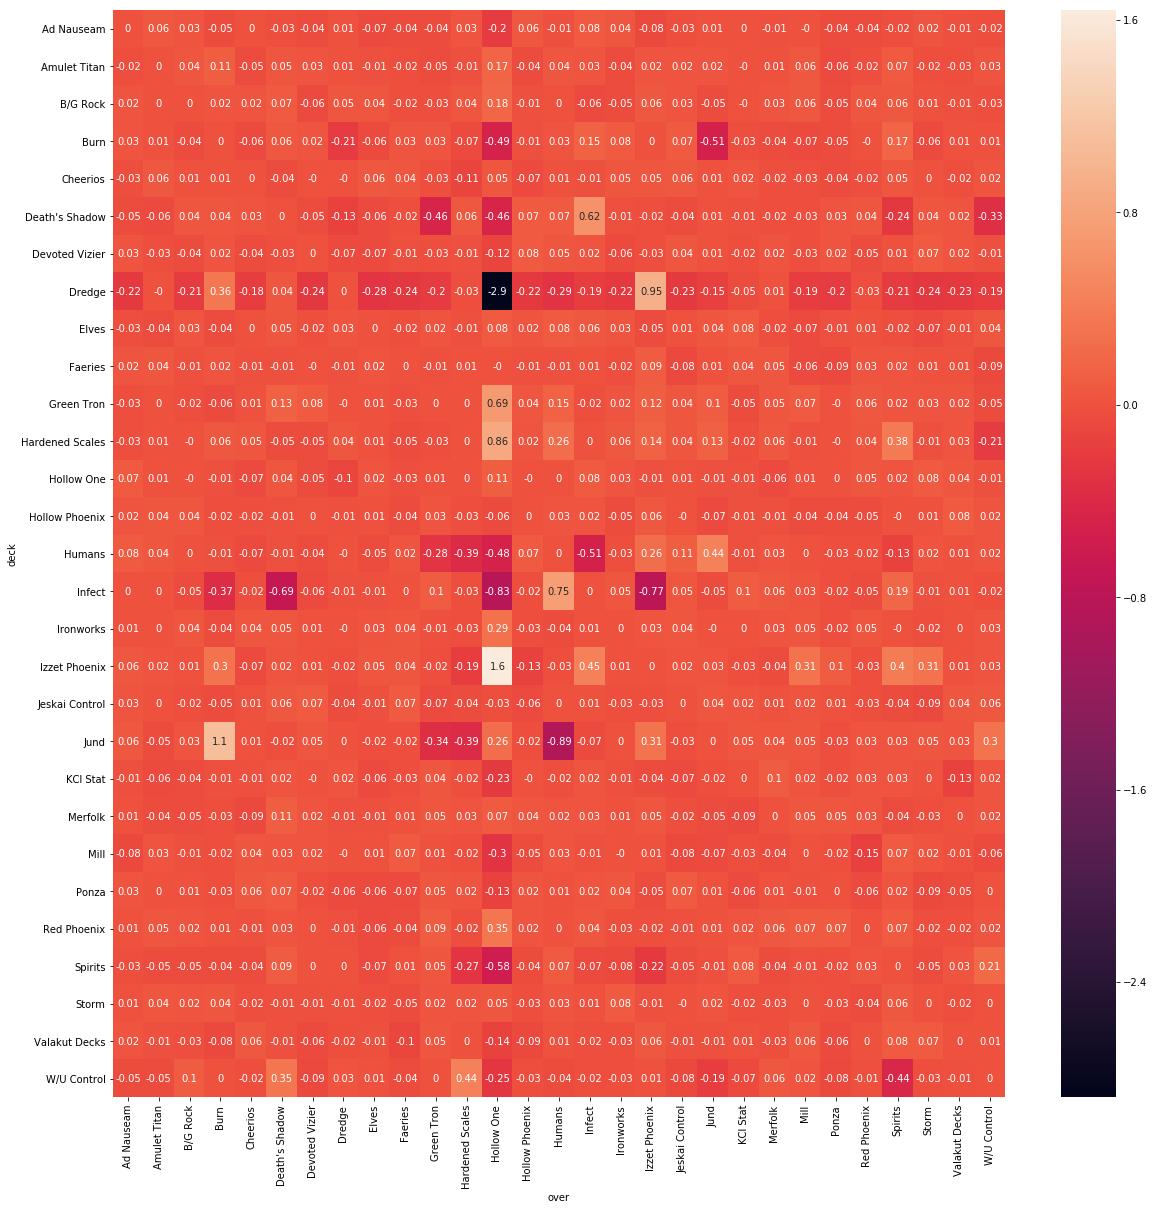

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (20, 20))
sns.heatmap(mat.set_index(["deck", "over"]).value.unstack(1).round(2).fillna(0), annot=True)

In [14]:
deck_sd_avg

,matchup_variance
deck,
Green Tron,0.306437
Spirits,0.310148
Hardened Scales,0.432455
Izzet Phoenix,0.641914
Burn,0.717115
Humans,0.921128
W/U Control,1.040029
Death's Shadow,1.279131
Infect,1.592233


In [15]:
mup = mat.set_index(["deck", "over"]).value.unstack(1).values * deck_sd_avg.values 
mup = mup - mup.T

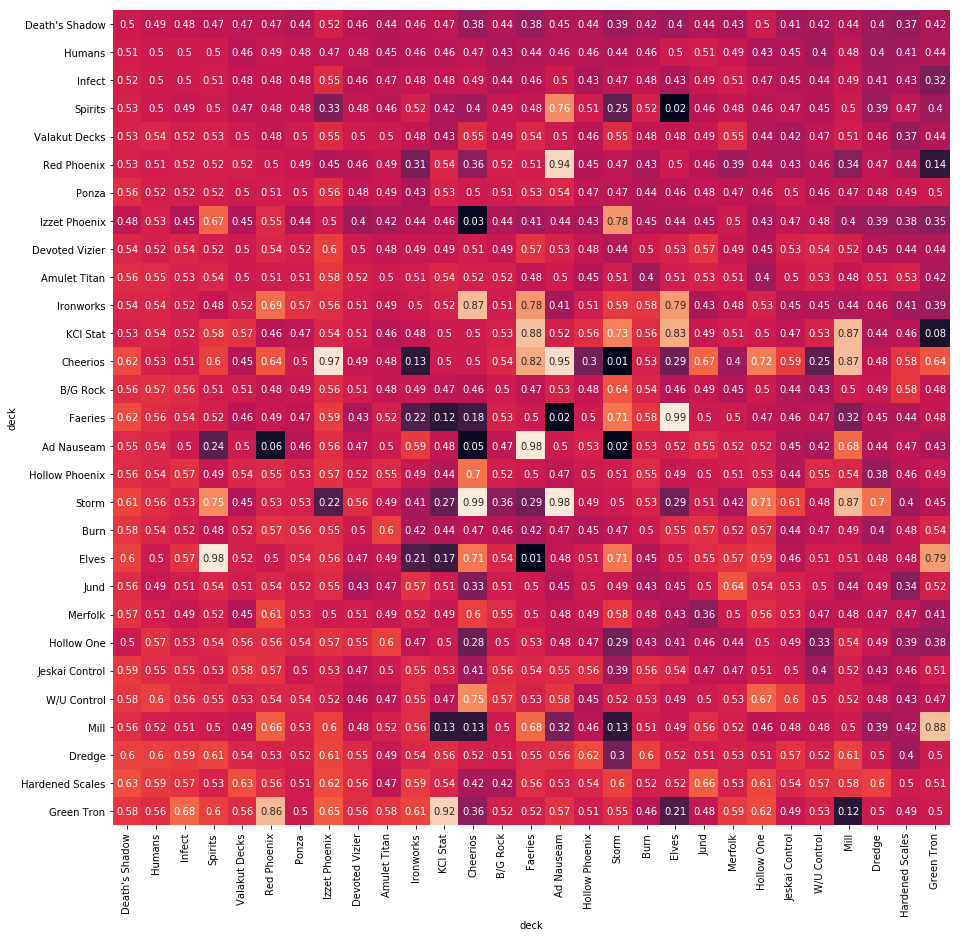

In [16]:
import numpy as np

plt.figure(figsize = (15, 15))
probs = (1 / (1 + np.exp(-(np.log(np.exp(deck_strengths_avg) @ np.exp(-deck_strengths_avg.T)) + mup).fillna(0))))
sns.heatmap(probs.round(2), annot=True, cbar = False)

In [17]:
metas = [{d: 1 for d in all_decks}] 

for i in range(1000): 
    
    meta = metas[i].copy()
    best = (probs.multiply(pd.Series(meta)).sum(axis = 1) / sum(meta.values())).idxmax()

    meta[best] += 1
    metas += [meta]


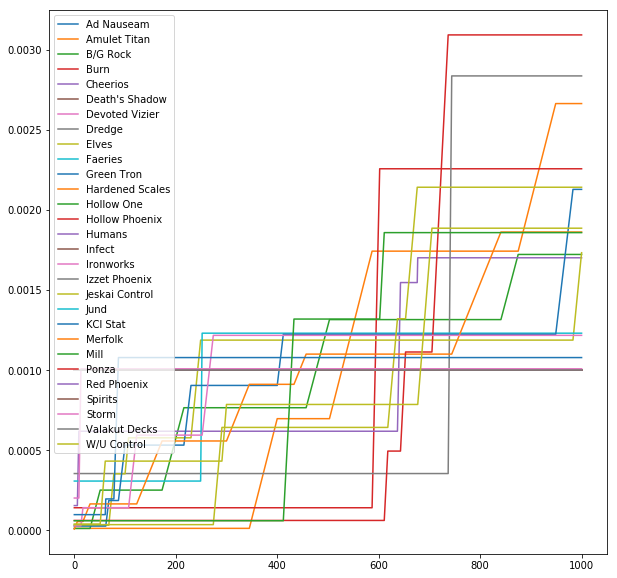

In [18]:
metas = pd.DataFrame(metas)
metas.div(metas.sum(axis = "rows")).plot(figsize = (10, 10))